In [15]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
from nn_resampler import nn_resampler
from phase_est_smc import phase_est_smc

In [17]:
num_particles = 1000 # number of SMC particles (num of w points)
num_samples = 10000 # number of samples to draw from the particle distribution (to be binned)
num_bins = 100 # number of bins
n_iters = 1000 # number of different omega*
t0 = 1 # starting time
max_iters = 50 # maximum number of iterations before breaking
if_print = True

In [18]:
net = nn_resampler(100,100)
net.load_state_dict(torch.load("model/nn_resampler.model"))
net.eval();

## NN Resampler

In [19]:
omega_star_list = []
nn_pred_list = []
nn_data = []

for i in range(n_iters): 
    
    omega_star = np.random.uniform(low=-1, high =1) * np.pi
    
    omega_star_list.append(omega_star)
    smc = phase_est_smc(omega_star, t0, max_iters)
    smc.init_particles(num_particles)
    resample_counts = 0
    
    while True:
        
        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        bins, edges = smc.get_bins(num_bins, num_samples)
        
        if smc.break_flag:
            break
            
        nn_pred = net(torch.tensor(bins).float().unsqueeze(0)) ## convert to float tensor, then make dim [1, num_bins]
        smc.nn_bins_to_particles(nn_pred.detach().numpy(), edges)
        
        resample_counts += 1

        
#         if len(running_est) > 5:
#             last_n = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shake of last_n with every element being last_n[0]
#             # if all elements of last_n are equal then they should all equal the first element
#             if np.allclose(last_n, np.full_like(last_n, last_n[0])):
#                 break
    if if_print:            
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(omega_star,
                                                                                             smc.curr_omega_est,
                                                                                             resample_counts))

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate
    
    nn_data.append(smc.data)
    nn_pred_list.append(smc.curr_omega_est)
    
    if abs(smc.curr_omega_est) - abs(omega_star) > 1:
        print("Prediction: {:f}, actual value: {:f}. Threshold exceeded. Breaking out of loop for inspection.".
             format(smc.curr_omega_est, omega_star))
        break

True omega: -0.946599, prediction by NN: -0.949402, num of resample calls: 3
True omega: -1.213076, prediction by NN: 1.139844, num of resample calls: 5
True omega: 1.004889, prediction by NN: 1.003273, num of resample calls: 4
True omega: 2.323806, prediction by NN: -2.229118, num of resample calls: 4
True omega: -2.995317, prediction by NN: -1.792637, num of resample calls: 4
True omega: 1.375875, prediction by NN: 1.366426, num of resample calls: 4
True omega: 2.179997, prediction by NN: -2.153358, num of resample calls: 2
True omega: -1.882321, prediction by NN: 1.854558, num of resample calls: 6
True omega: -2.774527, prediction by NN: 2.708146, num of resample calls: 4
True omega: -0.683272, prediction by NN: -0.663730, num of resample calls: 4
True omega: -1.581136, prediction by NN: 1.590686, num of resample calls: 2
True omega: 2.640282, prediction by NN: 2.643650, num of resample calls: 2
True omega: -0.351202, prediction by NN: 0.352230, num of resample calls: 3
True omega: 

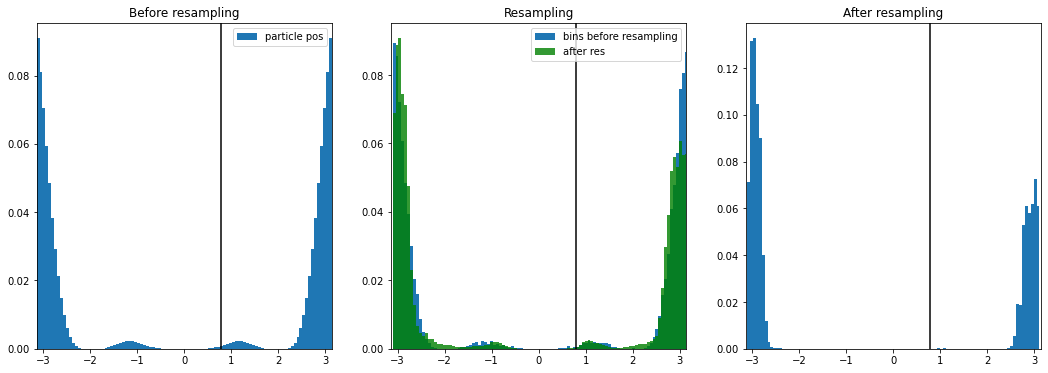

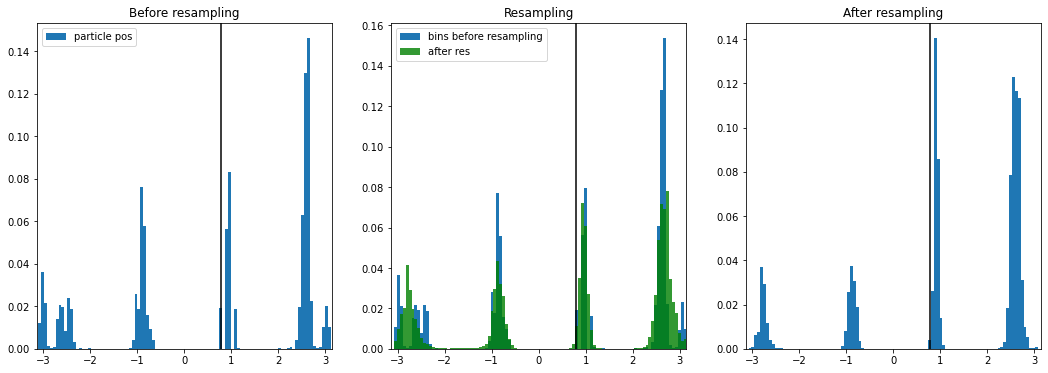

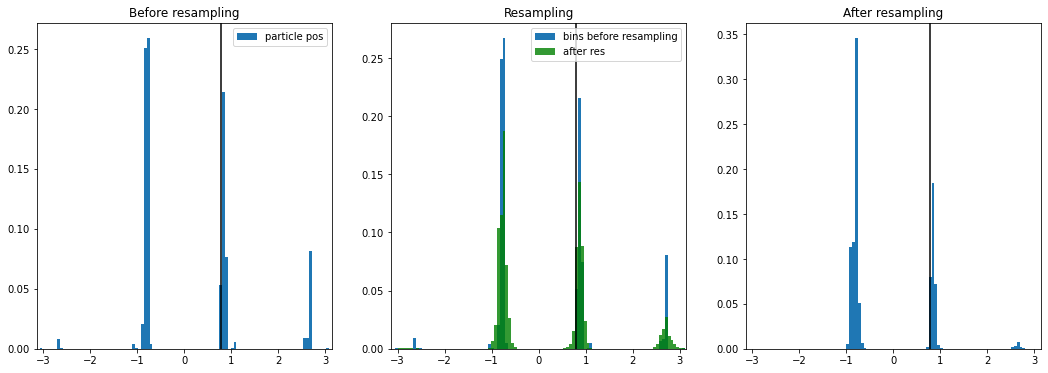

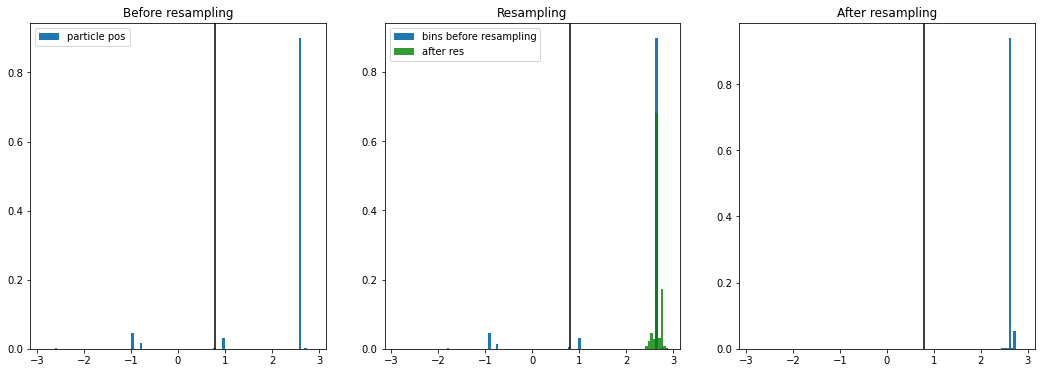

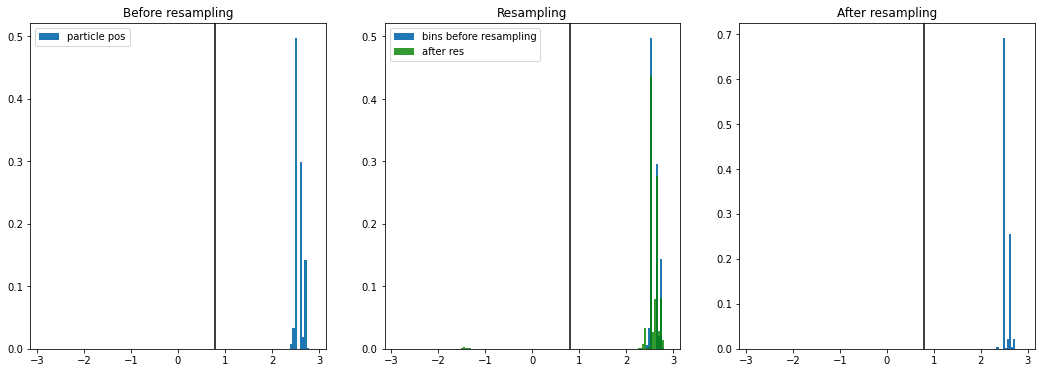

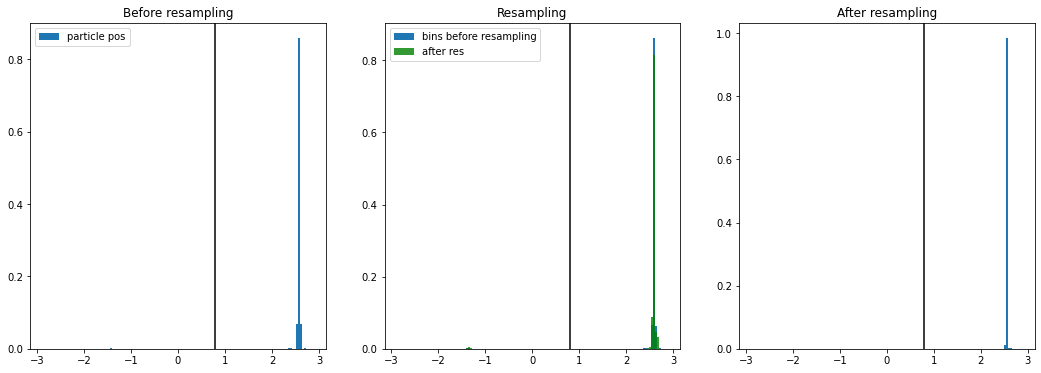

In [20]:
for i in range(len(smc.memory.pos_wgt_bef_res)-1):
    pos_bef_res = smc.memory.pos_wgt_bef_res[i][0]
    wgt_bef_res = smc.memory.pos_wgt_bef_res[i][1]
    bins_bef_res = smc.memory.bins_edges_bef_res[i][0]
    edges_bef_res = smc.memory.bins_edges_bef_res[i][1]
    bins_aft_res = smc.memory.bins_edges_aft_res[i][0]
    edges_aft_res = edges_bef_res
    pos_aft_res = smc.memory.pos_wgt_aft_res[i][0]
    wgt_aft_res = smc.memory.pos_wgt_aft_res[i][1]
    edge_width = edges_bef_res[1] - edges_bef_res[0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))
    
    ax1.hist(pos_bef_res, bins = num_bins, weights = wgt_bef_res, label='particle pos')
    #ax1.bar(edges_bef_res, bins_bef_res, align='edge', width = edge_width, alpha=0.5,color='green', label='bins before res')
    ax1.set_xlim([-np.pi, np.pi])
    ax1.axvline(omega_star,color='black')
    ax1.set_title("Before resampling")
    ax1.legend()
    
    ax2.bar(edges_bef_res, bins_bef_res, align='edge', width = edge_width, label='bins before resampling')
    ax2.bar(edges_aft_res, bins_aft_res, align='edge', width = edge_width, label='after res' ,alpha=0.8, color='green')
    ax2.set_xlim([-np.pi, np.pi])
    ax2.axvline(omega_star, color='black')
    ax2.set_title("Resampling")
    ax2.legend()
    
    ax3.hist(pos_aft_res, bins = num_bins, weights = wgt_aft_res)
    ax3.axvline(omega_star, color='black')
    ax3.set_xlim([-np.pi, np.pi])
    ax3.set_title("After resampling")
    
    plt.show()
    
    

## Liu-West resampler

In [21]:
omega_star_list = []
lw_pred_list = []
lw_data = []

for i in range(n_iters): 
    omega_star = np.random.uniform(low=-1, high=1) * np.pi
    
    omega_star_list.append(omega_star)
    smc = phase_est_smc(omega_star, t0, max_iters)
    smc.init_particles(num_particles)
    
    resample_counts = 0
    
    while True:

        particle_pos, particle_wgts = smc.particles(threshold=num_particles/10, num_measurements=1)
        smc.liu_west_resample()
    
        resample_counts += 1 
        
        curr_omega_est = smc.particle_pos[np.argmax(smc.particle_wgts)]
        if smc.break_flag == True:
            break
        
#         if len(running_est) > 5:
#             last_5 = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shape of last_10 with every element being last_10[0]
#             # if all elements of last_10 are equal then they should all equal the first element
#             if np.allclose(last_5, np.full_like(last_5, last_5[0])):
#                 break
                
      
    if if_print:            
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(omega_star,
                                                                                             smc.curr_omega_est,
                                                                                             resample_counts))

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate

    lw_data.append(smc.data)
    lw_pred_list.append(smc.curr_omega_est)
    
    if abs(smc.curr_omega_est) - abs(omega_star) > 1:
        print("Prediction: {:f}, actual value: {:f}. Threshold exceeded. Breaking out of loop for inspection.".
             format(smc.curr_omega_est, omega_star))
        break
    

True omega: 2.533453, prediction by NN: 2.451982, num of resample calls: 6
True omega: 0.408255, prediction by NN: -0.325809, num of resample calls: 5
True omega: -0.377276, prediction by NN: 0.460965, num of resample calls: 6
True omega: 0.554856, prediction by NN: -0.615064, num of resample calls: 5
True omega: 2.465497, prediction by NN: 2.600551, num of resample calls: 6
True omega: -0.540406, prediction by NN: -0.661460, num of resample calls: 5
True omega: 3.045167, prediction by NN: 3.356005, num of resample calls: 7
True omega: -2.299539, prediction by NN: -0.543441, num of resample calls: 7
True omega: 2.177988, prediction by NN: 3.397235, num of resample calls: 6
Prediction: 3.397235, actual value: 2.177988. Threshold exceeded. Breaking out of loop for inspection.


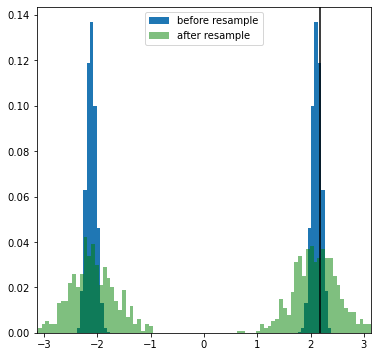

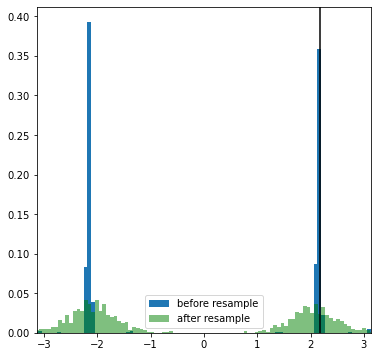

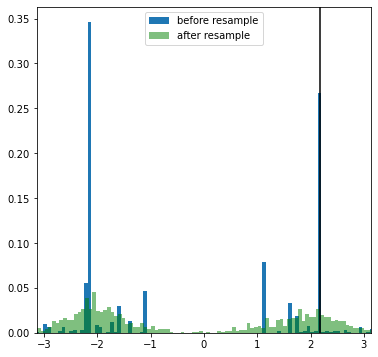

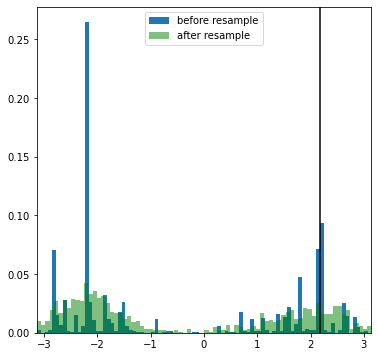

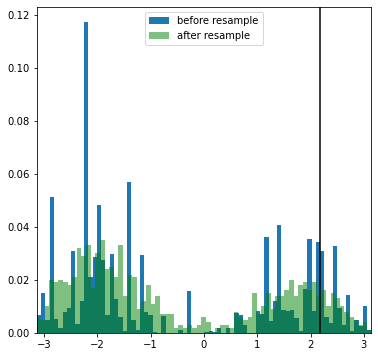

In [22]:
for i in range(len(smc.memory.pos_wgt_bef_res)-1):
    pos_bef_res = smc.memory.pos_wgt_bef_res[i][0]
    wgt_bef_res = smc.memory.pos_wgt_bef_res[i][1]
    pos_aft_res = smc.memory.pos_wgt_aft_res[i][0]
    wgt_aft_res = smc.memory.pos_wgt_aft_res[i][1]

    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    
    ax.hist(pos_bef_res, bins = num_bins, weights = wgt_bef_res, label='before resample')
    ax.hist(pos_aft_res, bins = num_bins, weights = wgt_aft_res, alpha=0.5, color='green', label='after resample')
    ax.set_xlim([-np.pi, np.pi])
    ax.axvline(omega_star,color='black')
    ax.legend()
    plt.show()
    
    